### Задание

Маркетологи запустили массивную рекламную кампанию, в результате в приложение пришло довольно много новых пользователей, вы можете видеть всплеск на графике активной аудитории.

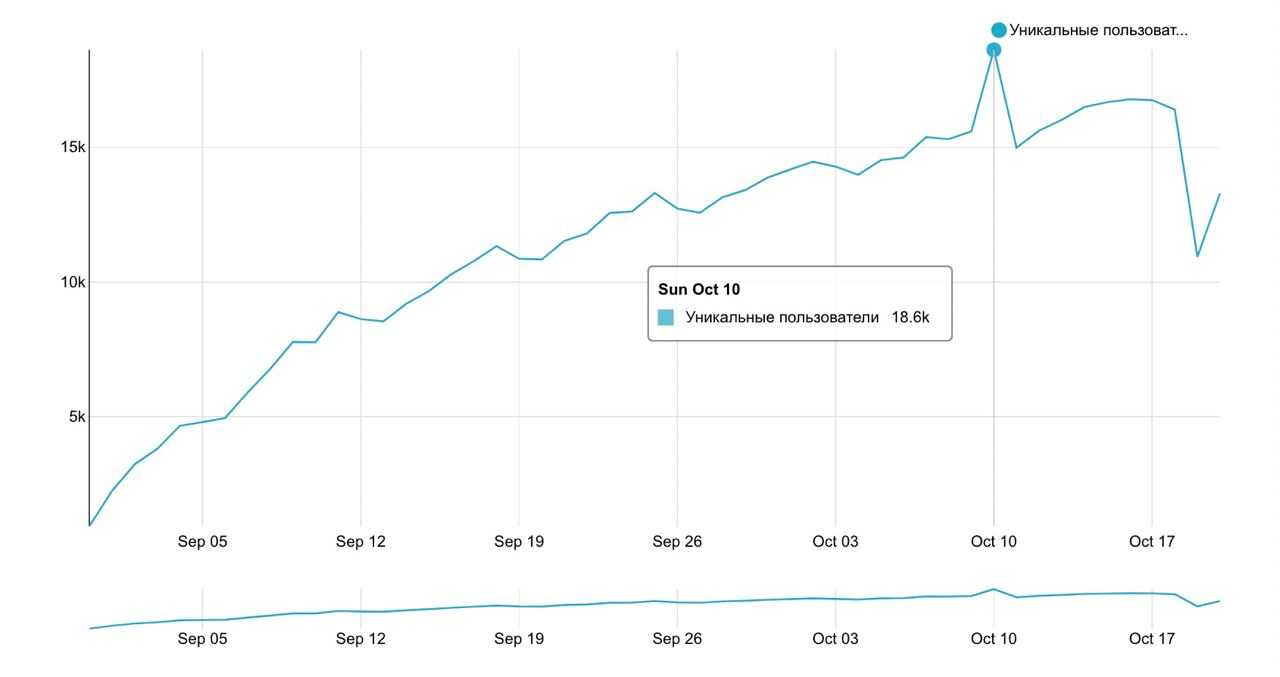

Однако у нас есть сомнение в качестве трафика, изучите, что стало с рекламными пользователями в дальнейшем, как часто они продолжают пользоваться приложением?

In [1]:
# Подгружаем библиотеки
import pandas as pd
import numpy as np
import pandahouse
import datetime as dt
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None
%matplotlib inline

plt.style.use('seaborn-whitegrid')

sns.set(font_scale = 1.25,
        style = 'whitegrid',
        rc = {'figure.figsize': (14, 5)})

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

Всплеск уникальных пользователей с рекламным источником трафика произошел 2022-10-16, это можно видеть на графике тут:
http://superset.lab.karpov.courses/r/2300

Достанем данные пользователей, которые в 2022-10-16 впервые зашли в приложение.

In [3]:
# Выгрузим данные всех юзеров, которые пришли в приложение 2022-10-16.
query = '''select * 
from 
    (select 
        user_id, 
        toDate(time) as time_of_action,
        source
    from simulator_20221020.feed_actions) as l
inner join 
    (select 
        user_id,
        toDate(min(time)) as first_visit
    from simulator_20221020.feed_actions
    group by user_id) as r
using user_id
where first_visit = toDateTime('2022-10-16')'''

In [4]:
df = pandahouse.read_clickhouse(query, connection = connection)

In [5]:
df.head(3)

,user_id,time_of_action,source,first_visit
0,147312,2022-10-29,organic,2022-10-16
1,147312,2022-10-29,organic,2022-10-16
2,147312,2022-10-29,organic,2022-10-16


In [6]:
df.shape

(385438, 4)

In [7]:
# Сколько уникальных юзеров пришло в приложение 2022-10-16 в разрезе по источнику трафика
df.groupby('source', as_index = False).agg({'user_id': pd.Series.nunique})

,source,user_id
0,ads,3688
1,organic,756


Видно, что в этот день через рекламу пришло в несколько раз больше новых пользователей.

In [8]:
# Создадим переменную, фиксирующую разницу между датой первого визита и датой действия в днях
df['day_after'] = (df.time_of_action - df.first_visit).dt.days
df.head(3)

,user_id,time_of_action,source,first_visit,day_after
0,147312,2022-10-29,organic,2022-10-16,13
1,147312,2022-10-29,organic,2022-10-16,13
2,147312,2022-10-29,organic,2022-10-16,13


Создадим два датафрейма - один с рекламными, другой с органическими пользователями.

In [9]:
ads_df = df.query('source == "ads"') \
    .groupby(['first_visit', 'day_after'], as_index = False) \
    .agg({'user_id': pd.Series.nunique}) \
    .rename(columns = {'user_id': 'amount_of_unique_users'})

organic_df = df.query('source == "organic"') \
    .groupby(['first_visit', 'day_after'], as_index = False) \
    .agg({'user_id': pd.Series.nunique}) \
    .rename(columns = {'user_id': 'amount_of_unique_users'})

Визуализируем ритеншен

<AxesSubplot:xlabel='day_after', ylabel='amount_of_unique_users'>

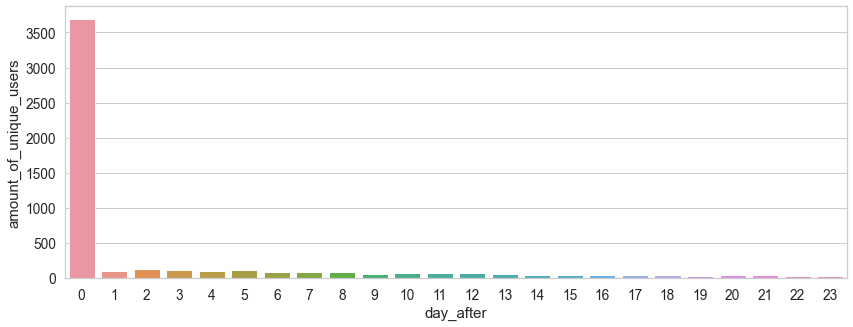

In [10]:
# Ритеншен рекламных пользователей
sns.barplot(data = ads_df, x = "day_after", y = "amount_of_unique_users")

<AxesSubplot:xlabel='day_after', ylabel='amount_of_unique_users'>

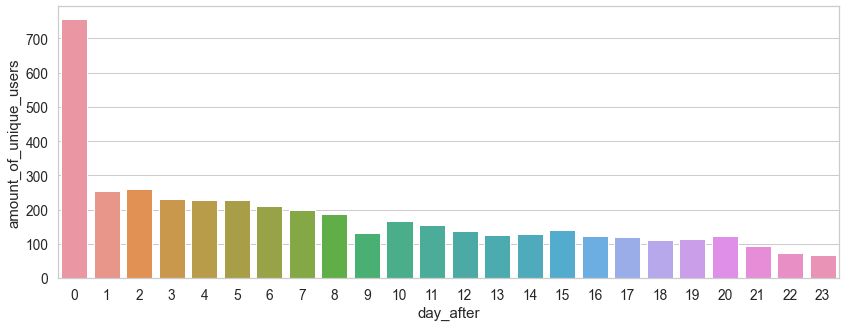

In [11]:
# Ритеншен органических пользователей
sns.barplot(data = organic_df, x = "day_after", y = "amount_of_unique_users")

Также можно посчитать Lifetime для каждой когорты:

In [12]:
print('Lifetime of organic cohort is', 
      round(organic_df.amount_of_unique_users.divide(organic_df.amount_of_unique_users[0], axis = 0).sum(), 2), 'days')

print('Lifetime of ads cohort is', 
      round(ads_df.amount_of_unique_users.divide(ads_df.amount_of_unique_users[0], axis = 0).sum(), 2), 'days')

Lifetime of organic cohort is 5.78 days
Lifetime of ads cohort is 1.44 days


Различия в средней продолжительности жизни пользователя в продукте довольно большие, как и различия в удержании - ритеншн 1-го, 7-го и 14-го дня среди рекламных пользователей ниже и в абсолютных, и в относительных значениях. Проверим, являются ли эти различия в ритеншене статистически значимыми.

In [13]:
data = organic_df.merge(ads_df, on = 'day_after', how = 'inner') \
    .drop('first_visit_y', axis = 1) \
    .rename(columns = {'first_visit_x': 'first_visit', 
                       'amount_of_unique_users_x': 'amount_of_unique_org_users',
                       'amount_of_unique_users_y': 'amount_of_unique_ads_users'})

data.head(3)

,first_visit,day_after,amount_of_unique_org_users,amount_of_unique_ads_users
0,2022-10-16,0,756,3688
1,2022-10-16,1,256,106
2,2022-10-16,2,260,124


In [14]:
p_values = []

for row in range(1, len(data)):
    stat, pval = proportions_ztest(np.array([data.loc[row, 'amount_of_unique_org_users'],
                                             data.loc[row, 'amount_of_unique_ads_users']]), 
                                   np.array([data.loc[0, 'amount_of_unique_org_users'],
                                             data.loc[0, 'amount_of_unique_ads_users']]), alternative = 'larger')
    
    p_values.append(pval)
    
data['p_value'] = [np.nan] + p_values

In [15]:
data

,first_visit,day_after,amount_of_unique_org_users,amount_of_unique_ads_users,p_value
0,2022-10-16,0,756,3688,NaN
1,2022-10-16,1,256,106,2.005844e-177
2,2022-10-16,2,260,124,9.958544e-169
3,2022-10-16,3,232,122,7.742872e-142
4,2022-10-16,4,228,108,4.492035e-147
5,2022-10-16,5,227,123,2.712934e-136
6,2022-10-16,6,212,93,2.425635e-141
7,2022-10-16,7,199,84,1.276357e-134
8,2022-10-16,8,188,88,1.049200e-120
9,2022-10-16,9,133,57,3.820453e-88


Вывод: существуют статистически значимые различия в показателях ритеншена для пользователей с различным источником трафика - у пользователей, пришедших в продукт в результате рекламной кампании, ритеншен значительно ниже в сравнении с органическими пользователями. Таким образом можно заключить, что качество рекламного трафика низкое, и пользователи, которые были привлечены в продукт рекламной кампанией, не очень активно возвращались обратно.